# 1D CME simulation to determine cell polarization via a signalling pathway
nicole pagane
10/24/17

### import necessary modules

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as snt
import scipy.stats as stats
from scipy.optimize import curve_fit

### parameters

In [244]:
# temperature
T = 295 #K

#viscosity of solution
eta = 1e-3 #Pa*s

#radius of substrate (assume the kinase is of similar size)
r = 1e-9 #m

#one-dimensional length of lattice gradient
L = 1.0e-3 #m

#number of compartments **INCLUDING THE 2 CONSTANT BOUNDARY SUBVOLUMES AND 3 CENTRAL SUBVOLUMES OF THE CELL**
K = 9

#iterations of the gillepsie algorithm
n = 100000

#how many runs to stochasticly simulate to get overall distribution
Sim = 50

#original far left and far right compartment species numbers
N = {}
N['A'] = np.asarray([20, 100])

#initial number of kinase molecules
c2 = 100

#initial number of singly phosphoylated kinase molecules
c3 = 5

#initial number of doubly phosphorylated kinase molecules
c4 = 0

### setup for deterministic solution to cell signalling pathway and parameter scan

In [278]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
#     K -> Kp      (k2)
#    Kp -> K       (k3)
#    Kp -> Kpp     (k4)
#   Kpp -> Kp      (k5)


# define intital values and parameters for the above kinetic rate laws
# model the concentration of substrate as a linear gradient 
c1 = 0 # technically N['A'][0] is the correct initial concentration if looking at the boundary
       # but lets assume 0 for the next right cell 
V = 1
y0 = np.asarray([c1, c2, c3, c4])/V #initial species concentration

# the following are dummy variables 
k1 = 100
k2 = 10
k3 = 10
k4 = 15
k5 = 20
ti = 0
tf = 10
t = np.linspace(ti, tf, n)

# define rates equations
def rates(y, t):
    return np.asarray([c1 + (N['A'][1] - N['A'][0])*(L/(K-2))/L, 
                      -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                      k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                      k4*y[2] -  k5*y[3]])

SyntaxError: invalid syntax (<ipython-input-278-5dda529c08b7>, line 21)

### solve for model with sets of parameters and plot

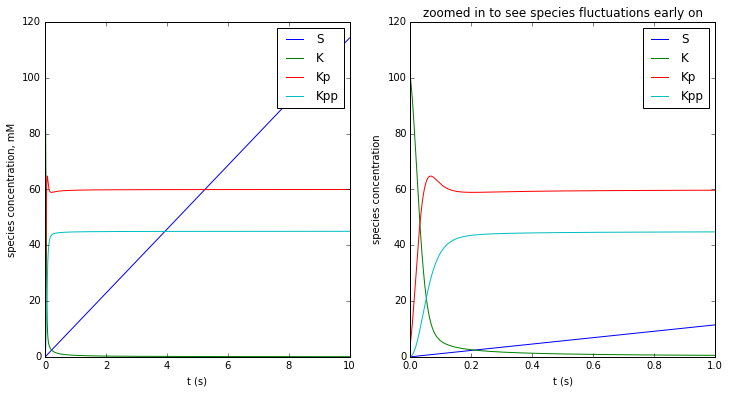

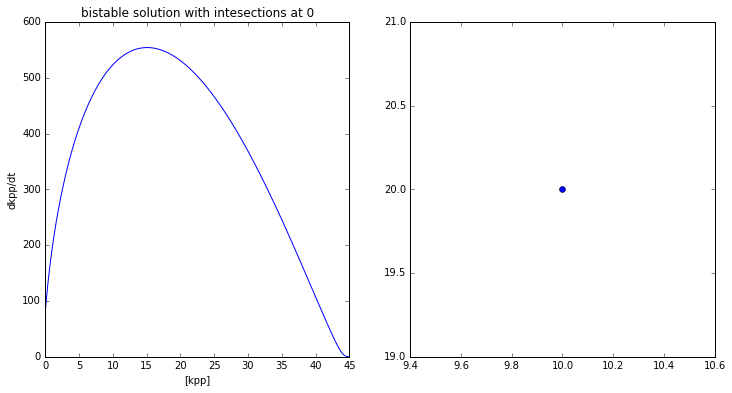

In [274]:
# solve the ODEs
ode = snt.odeint(rates, y0,t)

# plot species
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
tf = 10
t = np.linspace(ti, tf, n)
ode = snt.odeint(rates, y0,t)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])

#find dkpp/dt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
dkpp = np.diff(ode[:,3])/np.diff(t)
ax.plot(ode[:,3][0:n-1],dkpp)
ax.set_title('bistable solution with intesections at 0')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')

#plot two parameters against each other to determine bistable solution
ax = fig.add_subplot(1,2,2)
ax.plot(k2, k5, 'o')

plt.show()

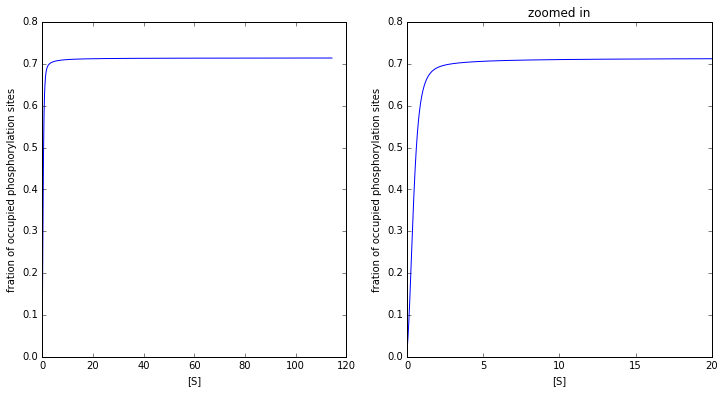

In [275]:
#plot fration of occupied phosphorylation sites to determine of parameters yield cooperativity 
# (sigmoidal as opposed to hyperbolic)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
ax = fig.add_subplot(1,2,2)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
plt.title('zoomed in')
ax.set_xlim([0, 20])

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


Hill constant, n: 0.0892561170935
Dissociation constant, kD: 0.570017248507


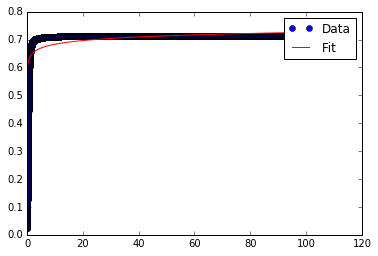

In [276]:
# Hill equation
def Hill(x, n , kD):
    return (x**n)/(kD + x**n)

popt, pcov = curve_fit(Hill, ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
plt.plot(ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])), 'o', label='Data')
plt.plot(ode[:,0],Hill(ode[:,0], popt[0], popt[1]), 'r-', label='Fit')
plt.legend()
print(''.join(['Hill constant, n: ', str(popt[0]), '\n', 'Dissociation constant, kD: ', str(popt[1])]))
plt.show()

### same deterministic solution as above but now with new definition for autophosphorylation reactions
 new definition forces nonlinearity 

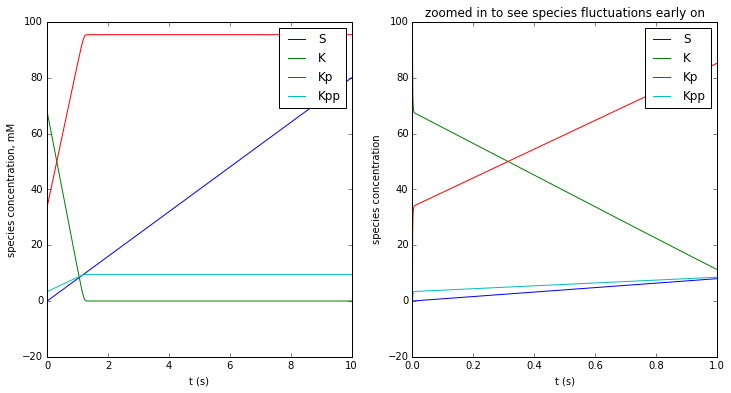

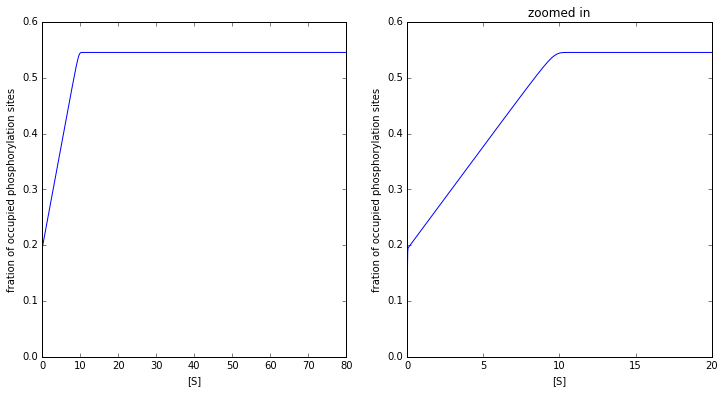

In [231]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)


# define rates equations
def rates(y, t):
    return np.asarray([(N['A'][1] - N['A'][0])/tf, 
                      -k1*y[0]*y[1] - 2*k2*y[1]**2 + k2*y[1]**2 + 2*k3*y[2]*y[1] - k3*y[2]*y[1],
                      k1*y[0]*y[1] + k2*y[1]**2 - k3*y[2]*y[1] - 2*k4*y[2]**2 + k4*y[2]**2 + 2*k5*y[3]*y[2] - k5*y[3]*y[2],
                      k4*y[2]**2 -  k5*y[3]*y[2]])

# solve the ODEs
ode = snt.odeint(rates, y0,t)

# plot species
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
tf = 10
t = np.linspace(ti, tf, n)
ode = snt.odeint(rates, y0,t)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])

#plot fration of occupied phosphorylation sites to determine of parameters yield cooperativity 
# (sigmoidal as opposed to hyperbolic)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
ax = fig.add_subplot(1,2,2)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
plt.title('zoomed in')
ax.set_xlim([0, 20])

plt.show()

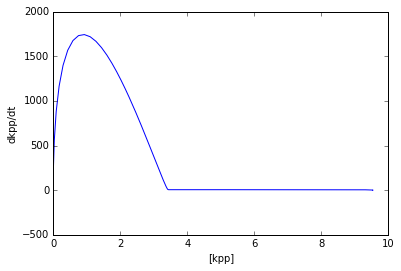

In [233]:
#find dkpp/dt
dkpp = np.diff(ode[:,3])/np.diff(t)
plt.plot(ode[:,3][0:n-1],dkpp)
plt.xlabel('[kpp]')
plt.ylabel('dkpp/dt')
plt.show()